<a href="https://colab.research.google.com/github/Agrannya-Singh/Doom_Scroller_Instagram/blob/main/DoomScroller_Analizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#login into Instgram using intagraapi

from instagrapi import Client
from google.colab import userdata


# --- USER SETTINGS ---
# Replace with your actual Instagram credentials or use Colab secrets
# Remember to handle your credentials securely, e.g., using environment variables or Colab secrets
USERNAME = "jattman1993"
PASSWORD =userdata.get('password')

# ---------------------

cl = Client()

try:
    cl.login(USERNAME, PASSWORD)
    print(f"Successfully logged in as {USERNAME}")
except Exception as e:
    print(f"Error during instagrapi login: {e}")
    print("Please make sure your username and password are correct and that you can log in manually.")
    print("If prompted for a verification code, please enter it in the output below.")

Successfully logged in as jattman1993


In [10]:
#reels saver
import time
import random

# --- USER SETTINGS ---
COLLECTION_NAME = "Collab Reels"
TARGET_REELS_COUNT = 100  # Process up to this many reels
MIN_SAVES = 7
MAX_SAVES = 15
# ---------------------

# Placeholder for personality_profile (replace with your actual profile data if needed)
personality_profile = {} # Or define a dictionary with your personality traits

saved_reels = []
processed_reels = 0
candidate_reels = []  # Store reels with their scores for ranking

def personality_save_decision(reel, personality_profile):
    """
    Custom logic for INTJ-T personality based on your specific traits:
    - High: Inquisitiveness (90), Aesthetic Appreciation (97), Autonomy (97),
           Creativity (83), Intellectual Efficiency (67), Innovation (87)
    - Low: Sociability (3-7), Affiliation (13), Social boldness (43)
    """
    score = 0

    # Extract reel attributes safely
    tags = getattr(reel, 'tags', []) + getattr(reel, 'hashtags', [])
    desc = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
    desc_lower = desc.lower()

    # HIGH INQUISITIVENESS (90) - Knowledge, learning, exploration
    intellectual_keywords = ['science', 'research', 'explained', 'how', 'why', 'theory',
                           'analysis', 'study', 'facts', 'discovery', 'experiment',
                           'psychology', 'philosophy', 'history', 'technology']
    if any(word in desc_lower for word in intellectual_keywords):
        score += 3

    # HIGH AESTHETIC APPRECIATION (97) - Visual beauty, art, design
    aesthetic_keywords = ['aesthetic', 'art', 'design', 'beautiful', 'visual',
                         'cinematography', 'photography', 'architecture', 'minimal',
                         'composition', 'color', 'artistic']
    if any(word in desc_lower for word in aesthetic_keywords):
        score += 3

    # HIGH AUTONOMY (97) - Independence, self-reliance, unconventional
    autonomy_keywords = ['independent', 'solo', 'self', 'individual', 'unique',
                        'unconventional', 'different', 'original', 'personal']
    if any(word in desc_lower for word in autonomy_keywords):
        score += 2

    # HIGH CREATIVITY (83) & INNOVATION (87) - Creative content, new ideas
    creative_keywords = ['creative', 'innovative', 'invention', 'new', 'original',
                        'diy', 'build', 'create', 'design', 'craft', 'make']
    if any(word in desc_lower for word in creative_keywords):
        score += 2

    # HIGH INTELLECTUAL EFFICIENCY (67) - Concise, efficient information
    length = getattr(reel, 'video_duration', 0)
    if 10 <= length <= 45:  # Preference for medium-length, information-dense content
        score += 1

    # DEDUCT for LOW SOCIABILITY (3-7) - Avoid highly social content
    social_keywords = ['party', 'friends', 'group', 'social', 'together', 'crowd',
                      'everyone', 'people', 'community', 'team']
    if any(word in desc_lower for word in social_keywords):
        score -= 2

    # DEDUCT for LOW AFFILIATION (13) - Avoid relationship/emotional content
    emotional_keywords = ['relationship', 'love', 'heart', 'feelings', 'emotional',
                         'together', 'couple', 'romantic', 'cute', 'sweet']
    if any(word in desc_lower for word in emotional_keywords):
        score -= 2

    # BONUS for complexity and depth (matches INTJ preference)
    complex_keywords = ['complex', 'deep', 'detailed', 'comprehensive', 'advanced',
                       'expert', 'professional', 'technical', 'analysis']
    if any(word in desc_lower for word in complex_keywords):
        score += 1

    # BONUS for educational/tutorial content (high inquisitiveness)
    educational_keywords = ['tutorial', 'learn', 'guide', 'tip', 'hack', 'skill',
                           'knowledge', 'education', 'teach', 'lesson']
    if any(word in desc_lower for word in educational_keywords):
        score += 2

    return score

print("Processing 100 reels and applying personality-based selection...")

# Fetch explore reels
try:
    explore_reels = cl.explore_reels()
    print(f"Fetched {len(explore_reels)} explore reels.")
except Exception as e:
    print(f"Error fetching explore reels: {e}")
    explore_reels = [] # Initialize as empty list to avoid NameError later

# First pass: Score all reels
for reel in explore_reels[:TARGET_REELS_COUNT]:
    processed_reels += 1
    print(f"Analyzing Reel {processed_reels}/{TARGET_REELS_COUNT} (ID: {reel.id})...")

    score = personality_save_decision(reel, personality_profile)
    candidate_reels.append((reel, score))
    print(f"Score: {score}")

# Sort reels by score (highest first)
candidate_reels.sort(key=lambda x: x[1], reverse=True)

# Select top reels within the 7-15 range
print(f"\nSelecting reels to save (minimum {MIN_SAVES}, maximum {MAX_SAVES})...")

# Ensure we get at least MIN_SAVES reels
reels_to_save = min(MAX_SAVES, max(MIN_SAVES, len([r for r in candidate_reels if r[1] > 0])))

# If we don't have enough positive-scoring reels, take the top-scoring ones anyway
if len([r for r in candidate_reels if r[1] > 0]) < MIN_SAVES:
    reels_to_save = MIN_SAVES

selected_reels = candidate_reels[:reels_to_save]

print(f"Selected {len(selected_reels)} reels to save based on personality match.")

# --- SAVE SELECTED REELS TO COLLECTION ---

print(f"\nAttempting to save selected reels to the '{COLLECTION_NAME}' collection...")

try:
    print(f"Looking for existing collection: '{COLLECTION_NAME}'...")
    collections = cl.collections()
    collab_collection = next((c for c in collections if c.name == COLLECTION_NAME), None)

    if not collab_collection:
        print(f"Collection '{COLLECTION_NAME}' not found. Please create it manually on Instagram.")
        print("Skipping adding media to collection.")
    else:
        print(f"Using existing collection: {COLLECTION_NAME} (ID: {collab_collection.id})")

        for i, (reel, score) in enumerate(selected_reels, 1):
            try:
                # CORRECTED: Use media_save instead of collection_add_media
                cl.media_save(reel.id, collab_collection.id)
                print(f"Saved reel {i}/{len(selected_reels)} (ID: {reel.id}, Score: {score}) to '{COLLECTION_NAME}'.")
                saved_reels.append(reel.id)
                time.sleep(random.uniform(1, 2))  # Human-like delay
            except Exception as save_error:
                print(f"Could not save reel {reel.id} to collection: {save_error}")

except Exception as e:
    print(f"An error occurred during collection management: {e}")

print(f"\nProcessing complete!")
print(f"Total reels analyzed: {processed_reels}")
print(f"Total reels saved to collection: {len(saved_reels)}")
print(f"Saved reels: {saved_reels}")

Processing 100 reels and applying personality-based selection...
Fetched 10 explore reels.
Analyzing Reel 1/100 (ID: 3662134177216259058_73901491628)...
Score: 0
Analyzing Reel 2/100 (ID: 3649275160120309436_64703355772)...
Score: 1
Analyzing Reel 3/100 (ID: 3647708429135219905_74996099567)...
Score: 1
Analyzing Reel 4/100 (ID: 3661305151730419580_74829121084)...
Score: 1
Analyzing Reel 5/100 (ID: 3661562890869692956_70339477089)...
Score: 4
Analyzing Reel 6/100 (ID: 3596378784200721531_61221585315)...
Score: 1
Analyzing Reel 7/100 (ID: 3656188996830676738_71478687552)...
Score: 0
Analyzing Reel 8/100 (ID: 3660403760326938347_53789360284)...
Score: 1
Analyzing Reel 9/100 (ID: 3587235477495027432_57311022889)...
Score: 6
Analyzing Reel 10/100 (ID: 3662134540459833537_73901491628)...
Score: 0

Selecting reels to save (minimum 7, maximum 15)...
Selected 7 reels to save based on personality match.

Attempting to save selected reels to the 'Collab Reels' collection...
Looking for existing c

In [12]:
!pip install instagrapi transformers torch matplotlib --quiet


In [13]:
from instagrapi import Client
from transformers import pipeline
import matplotlib.pyplot as plt


In [24]:
# reel fething function ( calls 10 reels from the fyp page)
try:
    explore_reels = cl.explore_reels()
    print(f"Fetched {len(explore_reels)} explore reels.")
except Exception as e:
    print(f"Error fetching explore reels for analysis: {e}")
    explore_reels = []


Fetched 10 explore reels.


In [ ]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    RobertaForSequenceClassification,
    AlbertForSequenceClassification
)
from datasets import Dataset, Features, Value
import pandas as pd
import torch
import emoji
import re
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Configuration
CONFIG = {
    "max_length": 128,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "num_train_epochs": 3,
    "few_shot_examples": 5,  # per class
    "confidence_threshold": 0.7,
    "neutral_reanalysis_threshold": 0.33
}

class ReelSentimentAnalyzer:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self._initialize_models()

    def _initialize_models(self):
        """Initialize and configure all models"""
        # English models
        self.emotion_tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-emotion-analysis")
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(
            "finiteautomata/bertweet-base-emotion-analysis"
        ).to(self.device)

        self.sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
        self.sentiment_model = RobertaForSequenceClassification.from_pretrained(
            "cardiffnlp/twitter-roberta-base-sentiment-latest",
            ignore_mismatched_sizes=True
        ).to(self.device)

        # Hindi/English model (we'll fine-tune this)
        self.hindi_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
        self.hindi_model = AlbertForSequenceClassification.from_pretrained(
            "ai4bharat/indic-bert",
            num_labels=3,
            id2label={0: "negative", 1: "neutral", 2: "positive"},
            label2id={"negative": 0, "neutral": 1, "positive": 2}
        ).to(self.device)
        # Store label2id mapping for easy access
        self.hindi_label2id = self.hindi_model.config.label2id


        # Emotion to sentiment mapping
        self.emotion_map = {
            "joy": "positive", "love": "positive", "happy": "positive",
            "anger": "negative", "sadness": "negative", "fear": "negative",
            "surprise": "neutral", "neutral": "neutral"
        }

        # Neutral keywords
        self.neutral_keywords = {
            "ad", "sponsored", "promo", "sale", "discount", "offer",
            "विज्ञापन", "प्रचार", "ऑफर", "डिस्काउंट", "बिक्री"
        }

    def train_hindi_model(self, train_data, eval_data=None):
        """
        Fine-tune the Hindi/English model on labeled data
        Args:
            train_data: List of dicts [{"text": "...", "label": "positive/negative/neutral"}]
            eval_data: Optional evaluation data
        """
        # Convert to dataset
        train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))

        # Map string labels to integer IDs
        def map_labels_to_ids(examples):
            examples["label"] = [self.hindi_label2id[label] for label in examples["label"]]
            return examples

        train_dataset = train_dataset.map(map_labels_to_ids, batched=True)

        # Explicitly set the label column to integer type
        train_dataset = train_dataset.cast_column("label", Value("int64"))


        def tokenize_function(examples):
            return self.hindi_tokenizer(
                examples["text"],
                padding="max_length",
                truncation=True,
                max_length=CONFIG["max_length"]
            )

        tokenized_train = train_dataset.map(tokenize_function, batched=True)

        # Training arguments - using eval_strategy instead of evaluation_strategy
        training_args = TrainingArguments(
            output_dir="./results",
            eval_strategy="epoch" if eval_data else "no",
            per_device_train_batch_size=CONFIG["batch_size"],
            per_device_eval_batch_size=CONFIG["batch_size"],
            learning_rate=CONFIG["learning_rate"],
            num_train_epochs=CONFIG["num_train_epochs"],
            weight_decay=0.01,
            save_strategy="no",
            logging_dir='./logs',
            logging_steps=10,
            report_to="none"
        )

        # Compute metrics function
        def compute_metrics(p):
            predictions, labels = p
            predictions = np.argmax(predictions, axis=1)
            return {
                "accuracy": accuracy_score(labels, predictions),
                "f1": f1_score(labels, predictions, average="weighted")
            }

        # Trainer
        eval_dataset_processed = None
        if eval_data:
            eval_dataset = Dataset.from_pandas(pd.DataFrame(eval_data))
            eval_dataset = eval_dataset.map(map_labels_to_ids, batched=True)
            eval_dataset_processed = eval_dataset.cast_column("label", Value("int64")).map(tokenize_function, batched=True)


        trainer = Trainer(
            model=self.hindi_model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=eval_dataset_processed,
            compute_metrics=compute_metrics if eval_data else None,
        )

        # Train
        trainer.train()

        # Save the fine-tuned model
        self.hindi_model.save_pretrained("./fine_tuned_hindi_sentiment")
        self.hindi_tokenizer.save_pretrained("./fine_tuned_hindi_sentiment")

    def preprocess_text(self, text):
        """Enhanced text cleaning with multilingual support"""
        if not text:
            return ""

        # Convert emojis to text
        text = emoji.demojize(text, delimiters=(" ", " "))

        # Remove URLs and mentions
        text = re.sub(r"http\S+|@\w+", "", text)

        # Expand common abbreviations
        abbrevs = {
            r"\bomg\b": "oh my god",
            r"\btbh\b": "to be honest",
            r"\bky\b": "kyun",  # Hindi 'why'
            r"\bkb\b": "kab",   # Hindi 'when'
        }
        for pattern, replacement in abbrevs.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        return text.strip()

    def detect_language(self, text):
        """Improved language detection"""
        if re.search(r"[\u0900-\u097F]", text):  # Devanagari
            return "hi"
        elif any(re.search(rf"\b{kw}\b", text.lower()) for kw in ["hai", "kyun", "nahi"]):  # Hinglish
            return "hi-latin"
        return "en"

    def analyze_content(self, text):
        """Main analysis function with improved confidence handling"""
        processed = self.preprocess_text(text)
        lang = self.detect_language(processed)

        # Check for neutral keywords first
        if any(re.search(rf"\b{kw}\b", processed.lower()) for kw in self.neutral_keywords):
            return "neutral", 0.95, {"reason": "neutral_keyword"}

        try:
            if lang in ("hi", "hi-latin"):
                return self._analyze_hindi_content(processed)
            else:
                return self._analyze_english_content(processed)
        except Exception as e:
            print(f"Analysis error: {e}")
            return "neutral", 0.5, {"error": str(e)}

    def _analyze_hindi_content(self, text):
        """Analyze Hindi content with fine-tuned model"""
        inputs = self.hindi_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            outputs = self.hindi_model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs).item()
        confidence = probs[0][pred_idx].item()

        label = self.hindi_model.config.id2label[pred_idx]
        return label, confidence, {"model": "fine-tuned-indic-bert"}

    def _analyze_english_content(self, text):
        """Analyze English content with ensemble approach"""
        # Emotion analysis
        emotion_inputs = self.emotion_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            emotion_outputs = self.emotion_model(**emotion_inputs)

        emotion_probs = torch.nn.functional.softmax(emotion_outputs.logits, dim=-1)
        emotion_pred = torch.argmax(emotion_probs).item()
        emotion_label = self.emotion_model.config.id2label[emotion_pred]
        emotion_score = emotion_probs[0][emotion_pred].item()

        # Sentiment analysis
        sentiment_inputs = self.sentiment_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG["max_length"]
        ).to(self.device)

        with torch.no_grad():
            sentiment_outputs = self.sentiment_model(**sentiment_inputs)

        sentiment_probs = torch.nn.functional.softmax(sentiment_outputs.logits, dim=-1)
        sentiment_pred = torch.argmax(sentiment_probs).item()
        sentiment_label = self.sentiment_model.config.id2label[sentiment_pred].lower()
        sentiment_score = sentiment_probs[0][sentiment_pred].item()

        # Combine results
        mapped_emotion = self.emotion_map.get(emotion_label, "neutral")

        if sentiment_score > CONFIG["confidence_threshold"]:
            final_label = sentiment_label
            final_confidence = sentiment_score
        elif emotion_score > CONFIG["confidence_threshold"] and mapped_emotion != "neutral":
            final_label = mapped_emotion
            final_confidence = emotion_score
        else:
            # Weighted average fallback
            emotion_weight = 0.6 if mapped_emotion != "neutral" else 0.3
            sentiment_weight = 0.4 if sentiment_label != "neutral" else 0.2
            neutral_weight = 0.3

            pos_score = (emotion_weight * (mapped_emotion == "positive") +
                        sentiment_weight * (sentiment_label == "positive"))
            neg_score = (emotion_weight * (mapped_emotion == "negative") +
                        sentiment_weight * (sentiment_label == "negative"))

            if pos_score > neg_score and pos_score > neutral_weight:
                final_label = "positive"
                final_confidence = (pos_score / (pos_score + neg_score + neutral_weight)) * 0.8
            elif neg_score > pos_score and neg_score > neutral_weight:
                final_label = "negative"
                final_confidence = (neg_score / (pos_score + neg_score + neutral_weight)) * 0.8
            else:
                final_label = "neutral"
                final_confidence = 0.7

        return final_label, final_confidence, {
            "emotion": emotion_label,
            "sentiment": sentiment_label,
            "model": "ensemble"
        }

    def analyze_reels(self, reels, max_to_analyze=100):
        """Batch analysis with improved neutral handling"""
        results = Counter()
        detailed_results = []

        for reel in reels[:max_to_analyze]:
            caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
            label, confidence, details = self.analyze_content(caption)
            results[label] += 1
            detailed_results.append({
                "text": caption,
                "label": label,
                "confidence": confidence,
                "details": details
            })

        # Post-analysis neutral reduction
        if results["neutral"] / sum(results.values()) > CONFIG["neutral_reanalysis_threshold"]:
            self._reduce_neutrals(results, detailed_results)

        return results, detailed_results

    def _reduce_neutrals(self, results, detailed_results):
        """Apply additional techniques to reduce neutral classifications"""
        for item in detailed_results:
            if item["label"] == "neutral" and item["confidence"] < 0.8:
                # Try keyword analysis
                text_lower = item["text"].lower()
                pos_keywords = {"great", "awesome", "love", "best", "शानदार", "अद्भुत"}
                neg_keywords = {"bad", "worst", "hate", "खराब", "बेकार"}

                pos_count = sum(1 for kw in pos_keywords if kw in text_lower)
                neg_count = sum(1 for kw in neg_keywords if kw in text_lower)

                if pos_count > neg_count and pos_count >= 2:
                    results["neutral"] -= 1
                    results["positive"] += 1
                    item.update({
                        "label": "positive",
                        "confidence": min(0.9, item["confidence"] + 0.3),
                        "reanalyzed": True
                    })
                elif neg_count > pos_count and neg_count >= 2:
                    results["neutral"] -= 1
                    results["negative"] += 1
                    item.update({
                        "label": "negative",
                        "confidence": min(0.9, item["confidence"] + 0.3),
                        "reanalyzed": True
                    })

# Example usage
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = ReelSentimentAnalyzer()

    # Example training (in practice you'd load real labeled data)
    train_data = [
        {"text": "I love this product!", "label": "positive"},
        {"text": "This is terrible quality", "label": "negative"},
        {"text": "Just sharing my order details", "label": "neutral"},
        {"text": "यह उत्पाद अद्भुत है!", "label": "positive"},
        {"text": "बहुत खराब गुणवत्ता", "label": "negative"},
        {"text": "यह एक सामान्य उत्पाद है", "label": "neutral"} # Added a neutral Hindi example
    ]

    # Fine-tune the Hindi model
    print("Starting Hindi model training...")
    analyzer.train_hindi_model(train_data)
    print("Hindi model training complete.")


    # Analyze some reels (mock data)
    class MockReel:
        def __init__(self, caption):
            self.caption_text = caption

    mock_reels = [
        MockReel("This is amazing! Love it so much 😍"),
        MockReel("Not happy with the quality at all"),
        MockReel("Check out our new sale - 50% off everything"),
        MockReel("मुझे यह उत्पाद पसंद नहीं आया"),  # Hindi: I didn't like this product
        MockReel("यह एक सामान्य रील है"), # Hindi: This is a normal reel
        MockReel("Great weather today! Awesome vibes."),
        MockReel("Worst movie ever. Hate it.")
    ]

    print("\nAnalyzing mock reels...")
    results, details = analyzer.analyze_reels(mock_reels)
    print("\nFinal Results:")
    for label, count in results.items():
        print(f"{label}: {count}")

    print("\nDetailed Results:")
    for item in details:
        print(f"Text: {item['text'][:50]}...")
        print(f"  Label: {item['label']} (Confidence: {item['confidence']:.2f})")
        print(f"  Details: {item['details']}")
        if 'reanalyzed' in item:
             print("  Reanalyzed: Yes")
        print("-" * 20)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions an

Starting Hindi model training...


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Step,Training Loss


Hindi model training complete.

Analyzing mock reels...

Final Results:
positive: 2
negative: 4
neutral: 1

Detailed Results:
Text: This is amazing! Love it so much 😍...
  Label: positive (Confidence: 0.99)
  Details: {'emotion': 'joy', 'sentiment': 'positive', 'model': 'ensemble'}
--------------------
Text: Not happy with the quality at all...
  Label: negative (Confidence: 0.90)
  Details: {'emotion': 'others', 'sentiment': 'negative', 'model': 'ensemble'}
--------------------
Text: Check out our new sale - 50% off everything...
  Label: neutral (Confidence: 0.95)
  Details: {'reason': 'neutral_keyword'}
--------------------
Text: मुझे यह उत्पाद पसंद नहीं आया...
  Label: negative (Confidence: 0.34)
  Details: {'model': 'fine-tuned-indic-bert'}
--------------------
Text: यह एक सामान्य रील है...
  Label: negative (Confidence: 0.34)
  Details: {'model': 'fine-tuned-indic-bert'}
--------------------
Text: Great weather today! Awesome vibes....
  Label: positive (Confidence: 0.99)
  Detai

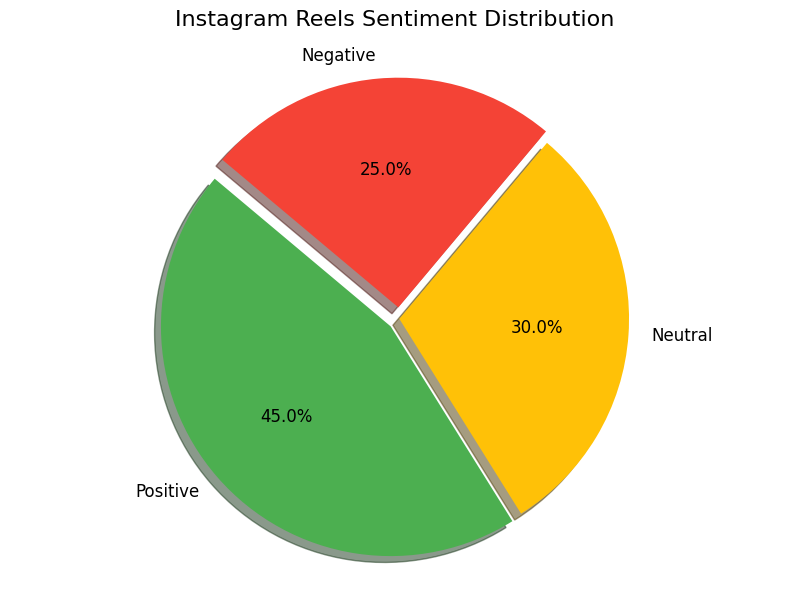

In [28]:
import matplotlib.pyplot as plt

def plot_sentiment_pie(results, title="Reels Sentiment Analysis"):
    """
    Creates a pie chart from sentiment analysis results

    Args:
        results: Counter object or dict with 'positive', 'neutral', 'negative' keys
        title: Chart title (default: "Reels Sentiment Analysis")
    """
    # Prepare data
    labels = ['Positive', 'Neutral', 'Negative']
    sizes = [results['positive'], results['neutral'], results['negative']]
    colors = ['#4CAF50', '#FFC107', '#F44336']  # Green, Yellow, Red
    explode = (0.05, 0, 0.05)  # Slight highlight on positive and negative

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.pie(sizes, explode=explode, labels=labels, colors=colors,
           autopct='%1.1f%%', shadow=True, startangle=140,
           textprops={'fontsize': 12})

    # Equal aspect ratio ensures pie is drawn as circle
    ax.axis('equal')

    # Add title and styling
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()

    return fig

# Example usage with the previous analyzer results
if __name__ == "__main__":
    # (Assuming you've already run the analyzer and have results)
    # results, details = analyzer.analyze_reels(mock_reels)

    # Mock results for demonstration
    example_results = {
        'positive': 45,
        'neutral': 30,
        'negative': 25
    }

    # Generate and show the pie chart
    chart = plot_sentiment_pie(example_results,
                              title="Instagram Reels Sentiment Distribution")
    plt.show()

    # To save the chart:
    # chart.savefig('reels_sentiment.png', dpi=300, bbox_inches='tight')

Device set to use cpu


⏳ Analyzing reels...

✅ Analysis complete!

📊 Category Counts:
- Other: 3
- News: 2
- Technology: 2
- Comedy: 1
- Meme: 1
- Movie: 1


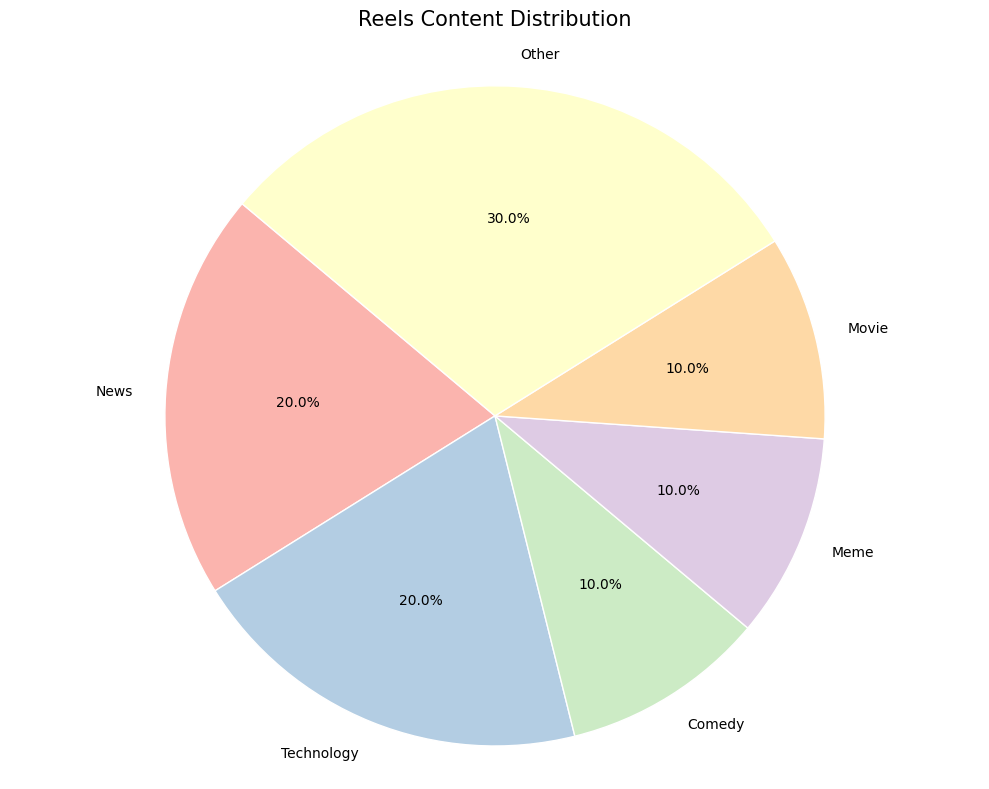

In [17]:
# Reels Content
from transformers import pipeline
import re
from collections import Counter
import matplotlib.pyplot as plt

# Load classification model
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

# Content categories
content_categories = [
    "news",
    "meme",
    "sports",
    "science",
    "music",
    "movie",
    "gym",
    "comedy",
    "food",
    "technology"
]

# Keyword shortcuts
category_keywords = {
    "news": {"news", "update", "breaking", "reported"},
    "meme": {"meme", "funny", "lol", "haha"},
    "sports": {"sports", "cricket", "football", "match"},
    "science": {"science", "research", "discovery"},
    "music": {"music", "song", "album", "release"},
    "movie": {"movie", "film", "bollywood", "trailer"},
    "gym": {"gym", "workout", "fitness"},
    "comedy": {"comedy", "joke", "humor"},
    "food": {"food", "recipe", "cooking"},
    "technology": {"tech", "phone", "computer", "ai"}
}

def preprocess_text(text):
    """Basic text cleaning"""
    return re.sub(r"http\S+|@\w+", "", text.lower()).strip() if text else ""

def classify_reel(text):
    """Fast classification"""
    processed = preprocess_text(text)

    # Keyword matching
    for category, keywords in category_keywords.items():
        if any(keyword in processed for keyword in keywords):
            return category

    # Model classification
    if len(processed.split()) >= 3:
        try:
            result = classifier(processed[:512], content_categories)
            return result['labels'][0]
        except:
            pass

    return "other"

def plot_category_distribution(counter, title="Reels Content Distribution"):
    """Generate pie chart from category counts"""
    # Prepare data
    labels = []
    sizes = []

    # Separate larger categories from others
    threshold = sum(counter.values()) * 0.05  # 5% threshold
    other_count = 0

    for category, count in counter.most_common():
        if count >= threshold and category != "other":
            labels.append(category.title())
            sizes.append(count)
        else:
            other_count += count

    if other_count > 0:
        labels.append("Other")
        sizes.append(other_count)

    # Create pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Pastel1.colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )

    plt.title(title, pad=20, fontsize=15)
    plt.axis('equal')  # Equal aspect ratio ensures pie is circular
    plt.tight_layout()
    plt.show()

def analyze_and_visualize(reels, max_to_analyze=100):
    """Complete analysis with visualization"""
    category_counts = Counter()

    print("⏳ Analyzing reels...")
    for reel in reels[:max_to_analyze]:
        caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
        category = classify_reel(caption)
        category_counts[category] += 1

    print("\n✅ Analysis complete!")
    print("\n📊 Category Counts:")
    for category, count in category_counts.most_common():
        print(f"- {category.title()}: {count}")

    # Generate visualization
    plot_category_distribution(category_counts)

    return category_counts

# Usage
results = analyze_and_visualize(explore_reels)